In [1]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [3]:
# Path to the dataset
!wget https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0 -O genres.tar.gz
!tar -xvf genres.tar.gz
DATASET_PATH = 'genres'

# Function to load the data
def load_data(dataset_path, genres, duration=30, sr=22050):
    features, labels = [], []

    for genre in genres:
        genre_path = os.path.join(dataset_path, genre)
        if not os.path.exists(genre_path):
            print(f"Directory does not exist: {genre_path}")
            continue

        for file_name in os.listdir(genre_path):
            file_path = os.path.join(genre_path, file_name)
            label = genres.index(genre)
            try:
                y, _ = librosa.load(file_path, duration=duration, sr=sr)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
                continue
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
            mfcc_scaled = np.mean(mfcc.T, axis=0)
            features.append(mfcc_scaled)
            labels.append(label)

    return np.array(features), np.array(labels)

# Define genres and load data
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
X, y = load_data(DATASET_PATH, genres)


--2024-08-06 23:38:44--  https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/logv7hsjc1t3daaysuhyh/genres.tar.gz?rlkey=vcu3jvliyletkjwxz8bv8jm7c&dl=0 [following]
--2024-08-06 23:38:44--  https://www.dropbox.com/scl/fi/logv7hsjc1t3daaysuhyh/genres.tar.gz?rlkey=vcu3jvliyletkjwxz8bv8jm7c&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8a70f62b1d6094b78b80ab54af.dl.dropboxusercontent.com/cd/0/inline/CYK-lV9Vob4VX5EfqBGH0ry2tpJgELpLjHQSt7d7K9-lYD900O5YFye38zUwYw7fSgLwnIsDqGNQUlqGcQLsEtx68M5-QbfeFF1jIEDKSP9Jhnzv8WbqeakSp8Hb1gtYguQ/file# [following]
--2024-08-06 23:38:45--  https://uc8a70f62b1d6094b78b80ab54af.dl.dropboxusercontent.com/cd/0/inline/CYK-

In [4]:
# Check if data was loaded
if X.size == 0 or y.size == 0:
    raise ValueError("No data loaded. Check if the dataset path and genre folders are correct.")

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encoding
y_train = to_categorical(y_train, num_classes=len(genres))
y_val = to_categorical(y_val, num_classes=len(genres))

# Reshape for CNN input
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]


In [7]:
# Model architecture
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(128, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(256, kernel_size=3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(pool_size=1),
        Dropout(0.3),

        Flatten(),

        Dense(256, activation='relu'),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])

    return model

# Create model
model = create_model((X_train.shape[1], 1), len(genres))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=32)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 38, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 38, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 19, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 17, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 17, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 6, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 6, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 6, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 6, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1536)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 521,354 (1.99 MB)

 Trainable params: 520,458 (1.99 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.1220 - loss: 3.3620 - val_accuracy: 0.1450 - val_loss: 2.2299
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1744 - loss: 2.7599 - val_accuracy: 0.2750 - val_loss: 2.0932
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2490 - loss: 2.4598 - val_accuracy: 0.3350 - val_loss: 2.0038
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3045 - loss: 2.2685 - val_accuracy: 0.3300 - val_loss: 1.9390
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3367 - loss: 2.1423 - val_accuracy: 0.3500 - val_loss: 1.8828
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2939 - loss: 2.1880 - val_accuracy: 0.3400 - val_loss: 1.8368
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.2919 - loss: 2.0288 - val_accuracy: 0.3600 - val_loss: 1.7886
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3092 - loss: 2.1187 - val_accuracy: 0.3500 - v

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5345 - loss: 1.3203 
Validation accuracy: 0.5299999713897705


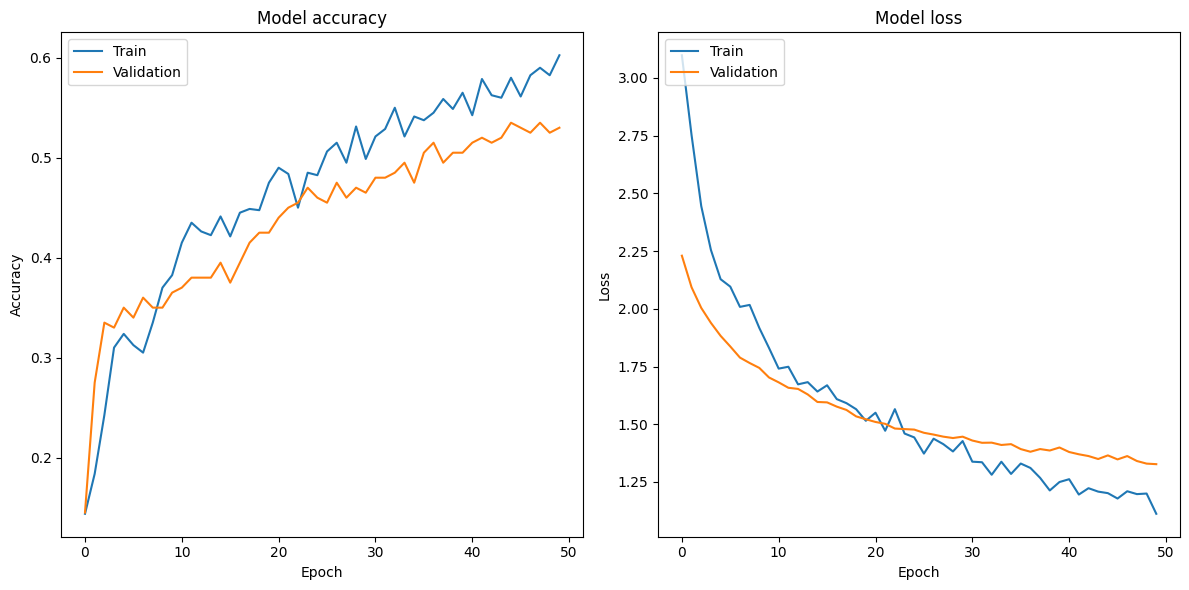

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


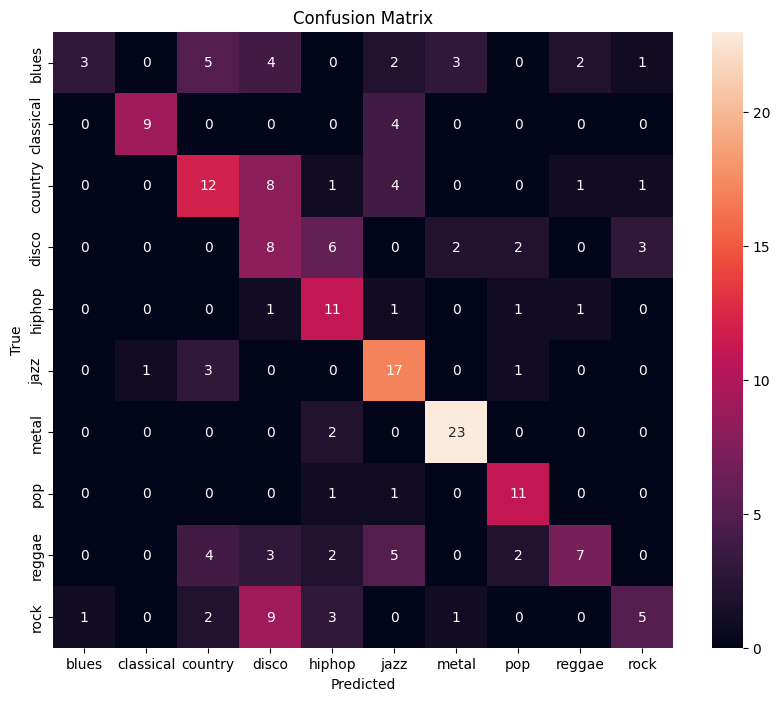

In [8]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_acc}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, genres):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=genres, yticklabels=genres)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Predict on validation data
y_val_pred = model.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

# Plot confusion matrix
plot_confusion_matrix(y_val_true, y_val_pred_classes, genres)

Validation accuracy: 0.530
Validation precision: 0.585
Validation recall: 0.548
Validation F1-score: 0.524


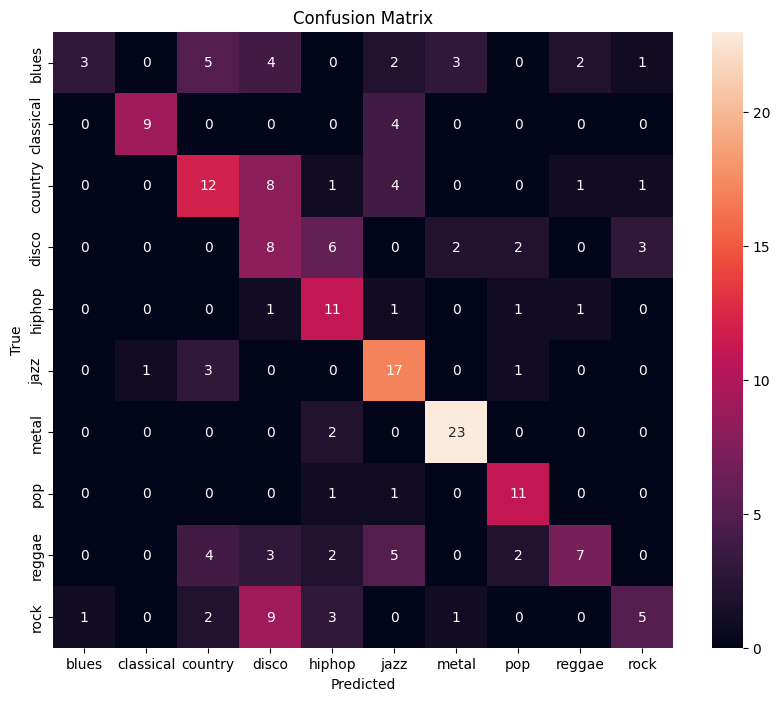

Genre-wise accuracy:
blues: 0.150
classical: 0.692
country: 0.444
disco: 0.381
hiphop: 0.733
jazz: 0.773
metal: 0.920
pop: 0.846
reggae: 0.304
rock: 0.238


In [10]:
# Calculate accuracy
accuracy = accuracy_score(y_val_true, y_val_pred_classes)
print(f'Validation accuracy: {accuracy:.3f}')

# Calculate precision, recall, and F1-score
precision = precision_score(y_val_true, y_val_pred_classes, average='macro')
recall = recall_score(y_val_true, y_val_pred_classes, average='macro')
f1 = f1_score(y_val_true, y_val_pred_classes, average='macro')
print(f'Validation precision: {precision:.3f}')
print(f'Validation recall: {recall:.3f}')
print(f'Validation F1-score: {f1:.3f}')

# Plot confusion matrix
plot_confusion_matrix(y_val_true, y_val_pred_classes, genres)

# Calculate genre-wise accuracy
genre_wise_accuracy = {}
for i, genre in enumerate(genres):
    genre_wise_accuracy[genre] = accuracy_score(y_val_true[y_val_true == i], y_val_pred_classes[y_val_true == i])
print("Genre-wise accuracy:")
for genre, accuracy in genre_wise_accuracy.items():
    print(f"{genre}: {accuracy:.3f}")